<a href="https://colab.research.google.com/github/Mohamed-Khalil67/Project_SARS-COV-2/blob/main/SARS_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#hide
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 41.7 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 189 kB 46.1 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 250 kB/s 


In [4]:
#hide
from fastai.vision.all import *
from fastbook import *

In [5]:
path = Path('drive/MyDrive/SARS-COVID/')

In [6]:
path.ls()


(#2) [Path('drive/MyDrive/SARS-COVID/COVID'),Path('drive/MyDrive/SARS-COVID/non-COVID')]

In [7]:
(path/'COVID').ls()[0]


Path('drive/MyDrive/SARS-COVID/COVID/Covid (141).png')

In [8]:
(path/'non-COVID').ls()[0]


Path('drive/MyDrive/SARS-COVID/non-COVID/Non-Covid (1060).png')

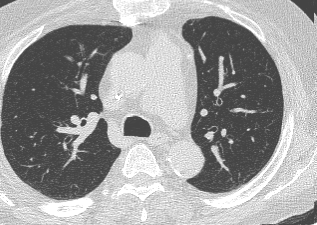

In [9]:
#looking into uploaded dataset images
import PIL

img1 = PIL.Image.open((path/'COVID').ls()[0])
img2 = PIL.Image.open((path/'non-COVID').ls()[0])

img1

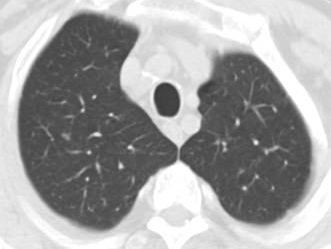

In [10]:
img2


## Creating a datablock to load data into the Model


We are then dividing the dataset in the train and valid set and We are using the random_state argument in order to replicate the result. The valid_pct argument represents the proportion of the dataset to include in the valid (in our case the 20%). Since we set the shufflue argument to True, the data will be shufflued before the split.

Now we need to import the dataset into this notebook. run the following code blocks to import the COVID dataset as a FastAI DataBlock

In the ImageDataBunch.from_name_list function we can see that we pass the dataset_dir we created earlier in the tutorial, fileNames that we created earlier, pattern for the files, some augmentation, the size of the images we need to replicate original model input sizes. data.show_batch()

This function to show a batch of our data. Run the code block to do this and view the results.

In [11]:
def get_dls(bs,size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=Resize(460),
                       #presizing is done 
                       #earlier size was 224 without progressive resizing but now including progressive resizing 
                       batch_tfms=[*aug_transforms(size=size,min_scale=0.75),
                       Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path,bs=bs)

In [12]:
dls=get_dls(128,128)
#without progressive resizing 
#training data loader for using progressive resizing currently not using it  

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


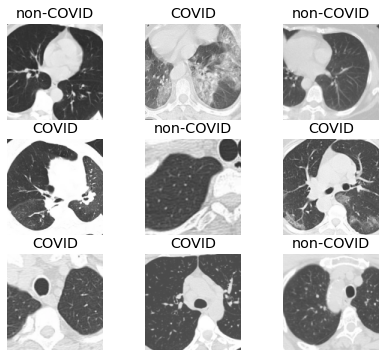

In [13]:
dls.show_batch(nrows=3, figsize=(7,6))


## Transfer Learning

### The Resnet50 model


Resnet50 generally is considered a good choice as first architecture to test, it shows good performance without an excessive size allowing to use a higher batch size and thus less computation time. For this reason, before to test more complex architectures Resnet50 is a good compromise.

Residual neural network have been ideated to solve this issue. The Resnet model presents the possibility to skip the training of some layer during the initial training. The skipped layer is reusing the learned weights from the previous layer. Original research article


Create the convolutional neural network First we will create the convolutional neural network based on this architechture, to do this we can use the following code block which uses FastAI ( cnn_learner previously create_cnn) function. We pass the loaded data, specify the model, pass error_rate & accuracy as a list for the metrics parameter specifying we want to see both error_rate and accuracy, and finally specify a weight decay of 1e-1 (1.0).

In [14]:
learn = cnn_learner(dls, xresnet50, metrics=[error_rate,accuracy], wd=1e-1).to_fp16()


Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


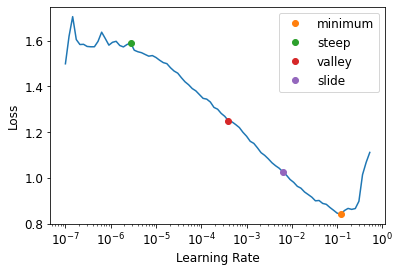

In [15]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min = lrs.minimum
lr_steep = lrs.steep


In [16]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")


Minimum/10: 1.20e-02, steepest point: 2.75e-06


In [17]:
learn.fit_one_cycle(4, 3e-3)
# learning with highest l.r training will be faster 

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.848931,2.021378,0.502016,0.497984,08:19
1,0.651006,0.605759,0.294355,0.705645,08:01
2,0.562624,0.350482,0.129032,0.870968,08:01
3,0.501397,0.286646,0.118952,0.881048,07:54


Test1

In [18]:
del learn
torch.cuda.empty_cache()

In [19]:
learn = cnn_learner(dls, xresnet50, metrics=[error_rate,accuracy], wd=1e-1).to_fp16()


/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [20]:
learn.fit_one_cycle(5, 3e-3)# best, Others Trials
# learning with highest l.r training will be faster 

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.820937,1.983538,0.485887,0.514113,07:53
1,0.633766,0.825245,0.338710,0.661290,07:53
2,0.506857,0.424841,0.193548,0.806452,07:54
3,0.459508,0.259722,0.104839,0.895161,07:53
4,0.414193,0.244415,0.100806,0.899194,07:59


In [21]:
del learn
torch.cuda.empty_cache()

In [22]:
learn = cnn_learner(dls, xresnet50, metrics=[error_rate,accuracy], wd=1e-1).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [23]:
learn.fit_one_cycle(5, 8e-3)
# learning with highest l.r training will be faster 

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.974999,1.997622,0.471774,0.528226,07:55
1,0.698533,0.465798,0.233871,0.766129,07:49
2,0.539053,0.320423,0.120968,0.879032,07:56
3,0.447982,0.330849,0.133065,0.866935,07:48
4,0.400999,0.269692,0.116935,0.883065,07:55


In [24]:
#learn.fit_one_cycle(5, lr_max=0.1)# learning with highest l.r training will be faster 


### Save the model
We can save the model once it has been trained. 

## ClassificationInterpretation()
We use  [ClassificationInterpretation()](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation) to visualize interpretations of our model.

## interp.plot_top_losses()
We can use [interp.plot_top_losses()](https://docs.fast.ai/vision.learner.html#plot_top_losses) to view our top losses and their details.

## interp.plot_confusion_matrix()
We will use  [interp.plot_confusion_matrix()](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation.plot_confusion_matrix) to display a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Below, 2 in the top left square represents  true negatives, while  in the top right square represent false positives, in the bottom left square represents false negatives, and in the bottom right represents true positives.

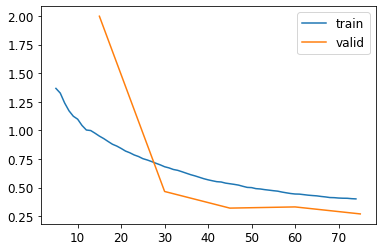

In [25]:
learn.recorder.plot_loss()# plot curves of training process


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


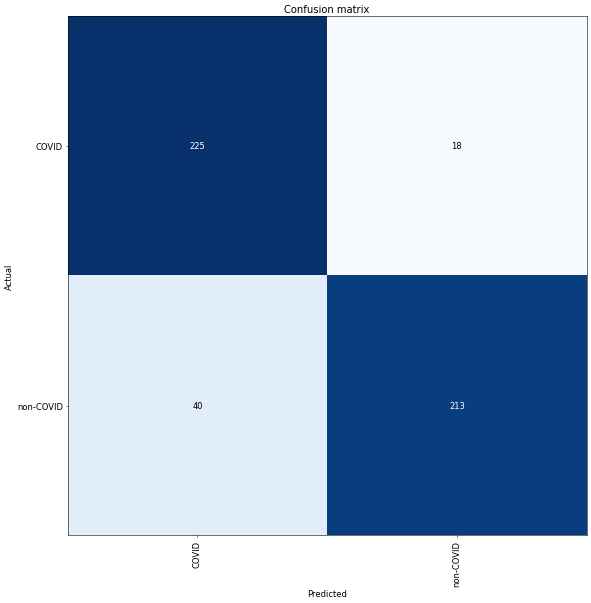

In [26]:
interp = ClassificationInterpretation.from_learner(learn)# plot confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=50)

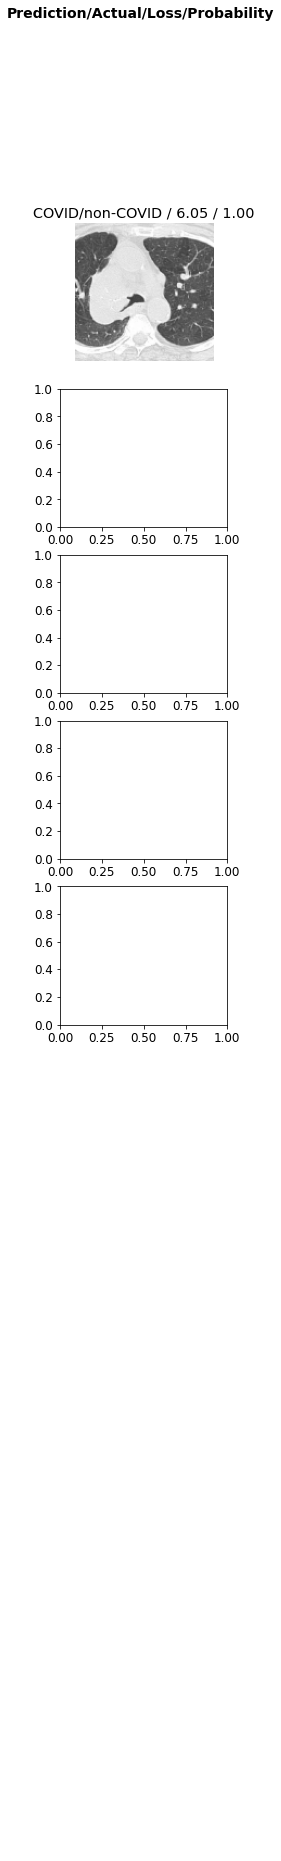

In [27]:
interp.plot_top_losses(5, nrows=10)# plot top losses 


#Unfreeze the model

## learn.unfreeze()
Next we use [learn.unfreeze()](https://docs.fast.ai/basic_train.html#Learner.unfreeze) to unfreeze the model. The original model was trained on ImageNet to classify images among 1000 categories. None of these categories is a leukemia cell, for these reason when fast.ai *cnn_learner* function is behind line substituting the last layer with 2 other layers. The last layer is a matrix that has the same size of our data class (*data.c*). Before, we just trained these two layers while the other model's layers were still keeping the downloaded weight. Unfreezing our model allow us to train also these other layers and updates their weights.

## Train the entire (unfrozen) model
Now that we have unfrozen our model, we will use the following code blocks to train the whole model.

##Slice parameter

Initial layers are activated by simple patterns (like edge, lines, circles etc...)  while the following layers are acquiring the ability to recognize more sophisticated patterns. Update too much the weight of these layers would probably decrease our accuracy. The scope of transfer learning is to exploit this ability of a pre-trained model in recognizing particular patterns and to adapt to our dataset. The parameter *slice* allows to apply ** discriminative learning rate**. In other words, we apply a smaller learning rate (in this case, 1e-5) to the earlier layer and a higher learning rate to the last layer.

## Save the model

We save our model after the un-freezing

In [28]:
learn.save("resnet50_c1")

Path('models/resnet50_c1.pth')

In [ ]:
learn.unfreeze()
learn.lr_find()# to finetune my model

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn.dls = get_dls(12, 224)# training on orignal size 

learn.fit_one_cycle( 12, slice(1e-5, 1e-4))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)# plot confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=50)

In [ ]:
interp.plot_top_losses(5, nrows=10)# plot top losses 

In [ ]:
learn.save('resnet50_run')

In [ ]:
learn.export()# for deploying we exported model, creates export.pkl

In [ ]:
path=Path()
path.ls(file_exts=".pkl")#get export file path

In [ ]:
learn_inf=load_learner(path/'export.pkl')


# Predicions from Our Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
img.shape

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(384,404))
out_pl

In [ ]:
dls.vocab

In [ ]:
pred,pred_idx,probs = learn.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
#Click event handler adds functionality to buttton
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
from fastai.vision.core import *
from ipywidgets import HBox,VBox,widgets,Button,Checkbox,Dropdown,Layout,Box,Output,Label,FileUpload

In [ ]:
HeatMp = widgets.Button(description='MAGIC')
HeatMp

In [ ]:
VBox([widgets.Label('INPUT YOUR CT SCAN IMAGE FOR DETECTION!'),
      btn_upload, btn_run, out_pl, lbl_pred,widgets.Label('Do You Want to See How our Model Decides which is Covid and Which is not?'),widgets.Label("Click Here"), HeatMp])